In [230]:
import numpy as np
import torch
import scipy.signal as sp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchaudio.functional import convolve
from torchaudio.transforms import InverseSpectrogram, Spectrogram, InverseSpectrogram
from IPython.display import Audio
from fb_utils import fir_tightener3000, fir_tightener4000, frame_bounds_lp, random_filterbank

In [3]:
with open('audfreqz.npy', 'rb') as f:
    gf = np.load(f)

In [4]:
import librosa
speech_full = librosa.load('speech.wav')
speech_full = librosa.resample(speech_full[0],orig_sr=22050,target_sr=16000)
len = 10000
speech = speech_full[1500:1500+len].reshape(1,-1)

x = torch.randn(32,1,len)
x[0,0,:] = torch.tensor(speech / np.linalg.norm(speech), dtype=torch.float32)

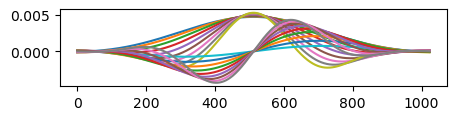

In [5]:
# Audlet style filterbank
supp = 1024
g = np.fft.ifft(gf, axis=0)
g = np.roll(g, supp//2, axis=0)
g_re = np.real(g[:supp]).T
g_im = np.imag(g[:supp]).T
g_c = g_re + 1j*g_im
g_re_tensor = torch.tensor(g_re, dtype=torch.float32).unsqueeze(1)
g_im_tensor = torch.tensor(g_im, dtype=torch.float32).unsqueeze(1)
# g_c_tensor = torch.tensor(g_c, dtype=torch.complex64).unsqueeze(1)

num = np.arange(1,10)
plt.figure(figsize=(5,1))
plt.plot(g_re[num,:].T)
plt.plot(g_im[num,:].T)
plt.show()

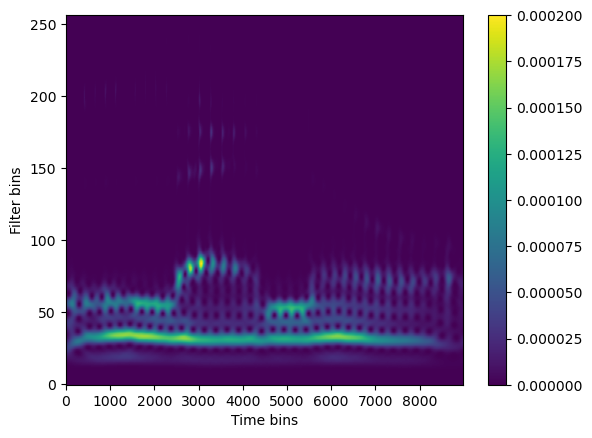

In [6]:
x_enc_re = F.conv1d(x, g_re_tensor, stride=1, padding=0)
x_enc_im = F.conv1d(x, g_im_tensor, stride=1, padding=0)
x_enc_mag = x_enc_re**2 + x_enc_im**2

plt.imshow(x_enc_mag.numpy()[0,:,:], vmin=0, vmax=0.0002, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_tilde_re = F.conv_transpose1d(x_enc_re, g_re_tensor, stride=1, padding=0).squeeze(0)
x_tilde_im = F.conv_transpose1d(x_enc_im, g_im_tensor, stride=1, padding=0).squeeze(0)
x_tilde = x_tilde_re + x_tilde_im

In [9]:
x_tilde.shape

torch.Size([32, 1, 10000])

In [10]:
Audio(data=x_tilde[0,:,:].numpy(), rate=16000)

In [19]:
g_re_tight = fir_tightener3000(g_re, 1024)
g_im_tight = fir_tightener3000(g_im, 1024)
g_tight = g_re_tight + 1j*g_im_tight
g_re_tight_tensor = torch.tensor(g_re_tight, dtype=torch.float32).unsqueeze(1)
g_im_tight_tensor = torch.tensor(g_im_tight, dtype=torch.float32).unsqueeze(1)

In [17]:
with open('aud_1024_re.npy', 'wb') as f:
    np.save(f, g_re_tight)

with open('aud_1024_im.npy', 'wb') as f:
    np.save(f, g_im_tight)

with open('aud_1024.npy', 'wb') as f:
    np.save(f, g_tight)

In [73]:
# random filterbank
supp_ran = 32
W_random = random_filterbank(supp_ran, 257, supp_ran, norm=False, tight=False, to_torch=False, support_only=True)
W_random = fir_tightener3000(W_random, supp_ran)
W_random_tensor = torch.tensor(W_random, dtype=torch.float32).unsqueeze(1)

In [214]:
stride = 1
stride_ran = 1

x_enc_re = F.conv1d(x, g_re_tight_tensor*160, stride=stride)
x_enc_im = F.conv1d(x, g_im_tight_tensor*160, stride=stride)

x_enc_re_both = F.conv1d(x_enc_re, W_random_tensor, stride=stride_ran, groups=257).squeeze(0)
x_enc_im_both = F.conv1d(x_enc_im, W_random_tensor, stride=stride_ran, groups=257).squeeze(0)

x_enc_ran = F.conv1d(x, W_random_tensor, stride=8).squeeze(0)

x_tilde_re = F.conv_transpose1d(x_enc_re, g_re_tight_tensor/160, stride=stride).squeeze(0)
x_tilde_im = F.conv_transpose1d(x_enc_im, g_im_tight_tensor/160, stride=stride).squeeze(0)

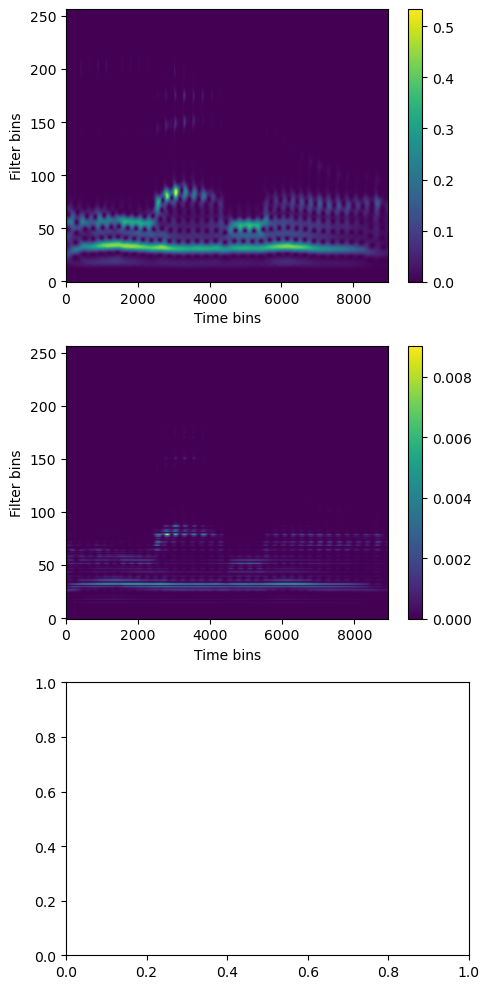

In [216]:
# magnitude response
x_enc_mag = x_enc_re**2 + x_enc_im**2

x_enc_mag_both = x_enc_re_both**2 + x_enc_im_both**2

# reconstruction
x_tilde = (x_tilde_re + x_tilde_im)/2*stride

# figure size
plt.figure(figsize=(5,10))

plt.subplot(3,1,1)
plt.imshow(x_enc_mag.numpy()[0,:,:], vmin=0, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

plt.subplot(3,1,2)
plt.imshow(x_enc_mag_both.numpy()[0,:,:], vmin=0, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

plt.subplot(3,1,3)
# plt.plot(x[0,:,:].T-x_tilde[0,:,:].T)
# plt.plot(x[0,:,:].T, alpha=0.5)

plt.tight_layout()
plt.show()

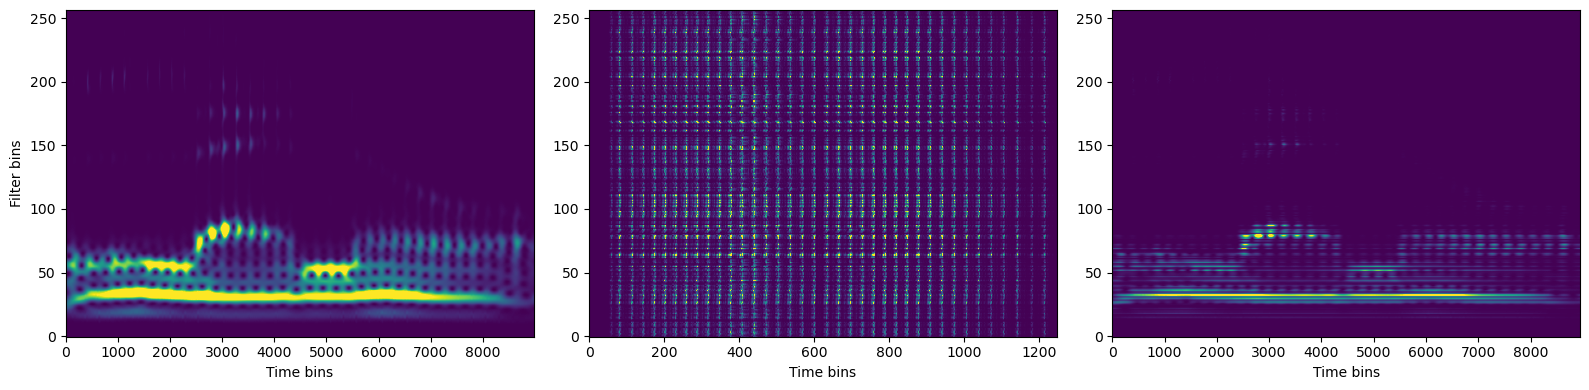

In [217]:
# imshow the enc
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_enc_mag.numpy()[0,:,:]/np.max(x_enc_mag.numpy()[0,:,:]), vmax=0.5, aspect='auto')
# flip y ticks  to have 0 at the bottom
plt.gca().invert_yaxis()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')
#plt.title('Auditory FIR filters')

plt.subplot(1, 3, 3)
plt.imshow(x_enc_mag_both.numpy()[0,:,:]/np.max(x_enc_mag_both.numpy()[0,:,:]), vmax=0.4, aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Time bins')
#plt.title('Random FIR filters')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(x_enc_ran[0,:,:].numpy())**2/np.max(np.abs(x_enc_ran[0,:,:].numpy())**2), vmax=0.2, aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Time bins')
#plt.title('Inductively biased FIR filters')

plt.tight_layout()
plt.savefig('responses2.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [218]:
from scipy.interpolate import interp1d

In [213]:
x_red.shape

(257, 36)

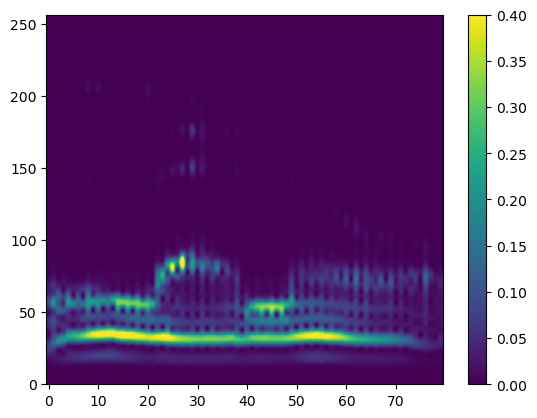

In [225]:
coef_both = np.zeros_like(x_enc_mag_both.numpy()[0,:,:])

M = coef_both.shape[0]
Nc = coef_both.shape[1]
f = interp1d(np.linspace(0, 1, Nc), x_enc_mag_both.numpy()[0,:,:], kind='nearest', axis=1)
C_both = f(np.linspace(0, 1, 36))

x_red = x_enc_mag.numpy()[0,:,:]

coef = np.zeros_like(x_red)

M = coef.shape[0]
Nc = coef.shape[1]
f = interp1d(np.linspace(0, 1, Nc), x_red, kind='linear', axis=1)
C = f(np.linspace(0, 1, 80))

plt.imshow(C, aspect='auto', origin='lower', vmin=0, vmax=0.4)
plt.colorbar()

In [275]:
torch.full_like(torch.tensor(x_2), 1)

tensor([[1., 1., 1.,  ..., 1., 1., 1.]])

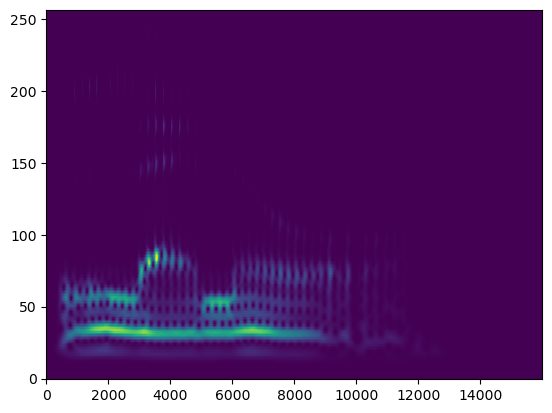

In [234]:
x_2 = speech_full[1500:1500+16000].reshape(1,-1)

x_2_enc = np.fft.ifft(np.fft.fft(x_2, axis=1)*gf.T, axis=1)

plt.imshow(np.abs(x_2_enc)**2, aspect='auto', origin='lower',interpolation='nearest')

In [45]:
Audio(data=x_tilde[0,:,:].numpy(), rate=16000)

In [260]:
np.mod(8000,256)

64

In [54]:
torch.norm(x_enc_stft[0,0,:,:]), torch.norm(x_enc_mag[0,:,:]), torch.norm(x_enc_mag_both[0,:,:])

(tensor(13.6876), tensor(23.5997), tensor(0.0921))

In [51]:
x_enc_stft[0,0,:,:].shape, x_enc_mag[0,:,:].shape, x_enc_mag_both[0,:,:].shape

(torch.Size([257, 40]), torch.Size([257, 562]), torch.Size([257, 547]))